In [14]:
import sys, os, time
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform,Pn5AAKWaveform, AAKWaveformBase
from few.summation.aakwave import AAKSummation
from few.utils.utility import *

import GWGen; from GWGen.WFGenerator import *
from GWGen.Utils import *

# set initial parameters
M = 100000.0
mu = 1e1
a = .6
e0 = 0.6
p0=GetInitialP(M,e0)
iota0 = 0.
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 = 0.
Phi_r0 = 0.

qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15
T = 6

use_gpu = False

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e4),  # all of the trajectories will be well under len = 1000
    "npoints":110,
    "dense_output":False,
    "func":"pn5"
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

fewtraj = EMRIInspiral(func="pn5")
fewwav = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=False)
mytraj = PNTraj()
mywav = EMRIWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=False)


In [2]:
# run trajectory
fewtrajdata = fewtraj(M, mu, a, p0, e0, Y0, T=T,dt=dt,**inspiral_kwargs)
mytrajdata = mytraj(M,mu,a, p0,e0,Y0,T=T,**inspiral_kwargs)

In [15]:
#run waveform
mywf = mywav(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)
FEWwaveform = fewwav(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

In [16]:
cl = Kerr(BHSpin=0.9)
dat = mytrajdata
for inx in range(len(dat[0])):
    try:
        cl.OrbitalFrequencies()(dat[2][inx], dat[1][inx],1.)
    except SystemError as err:
        print(dat[2][inx])
        print(dat[1][inx])
        print(err)

In [17]:
AAK = AAKWaveformBase(EMRIInspiral, AAKSummation,inspiral_kwargs=inspiral_kwargs.copy(), sum_kwargs=sum_kwargs.copy(),use_gpu=use_gpu)

In [18]:
dat = tuple((np.require(i, dtype=np.float64, requirements="O") for i in fewtrajdata))
num_modes_kept = nmodes = int(30 * e0)
if num_modes_kept < 4:
    num_modes_kept = nmodes = 4
fewwf = AAK.create_waveform(dat[0], M, a,*dat[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)

In [6]:
dat = mytrajdata
num_modes_kept = nmodes = int(30 * e0)
if num_modes_kept < 4:
    num_modes_kept = nmodes = 4
mywf = AAK.create_waveform(dat[0], M, a,*dat[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)

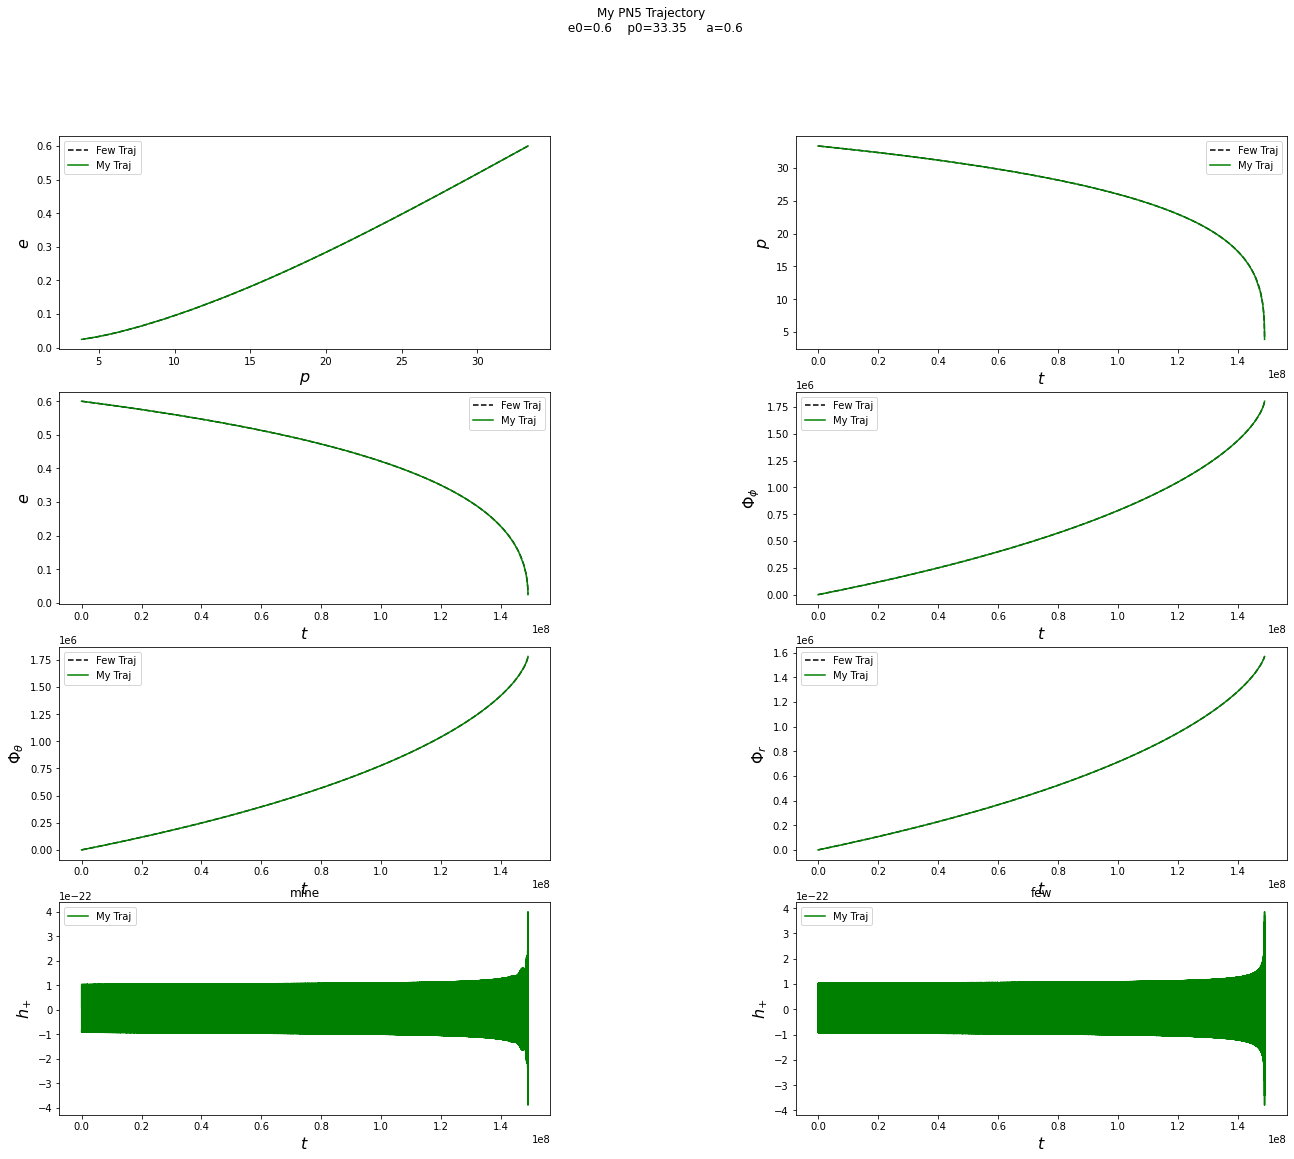

In [7]:
#Plot Trajectories
fig, axes = plt.subplots(4, 2)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(22, 18)
axes = axes.ravel()
ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_\theta$', r'$\Phi_r$', r'$h_{+}$',r'$h_{+}$']
xlabels = [r'$p$', r'$t$',  r'$t$',  r'$t$',               r'$t$',                     r'$t$',            r'$t$',  r'$t$']
datlabel = ["Few Traj",  "My Traj"]
datcolors = ["black", "green", "blue", "yellow", "orange"]
datstyle= ["dashed", "solid", "dashdot", "dotted"]
xdata = [1,0,0,0,0,0]
ydata = [2,1,2,4,5,6]
for i, (ax, xlab, ylab) in enumerate(zip(axes, xlabels, ylabels)):
    if i<len(xdata):
        fx = fewtrajdata[xdata[i]]
        fy = fewtrajdata[ydata[i]]
        mx = mytrajdata[xdata[i]]
        my = mytrajdata[ydata[i]]
        ax.plot(fx,fy, label=datlabel[0],color=datcolors[0], linestyle=datstyle[0])
        ax.plot(mx,my, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])
    elif i==len(xdata):
        mx = np.arange(len(mywf))*dt
        my = mywf.real
        ax.plot(mx,my, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])
        ax.set_title("mine")
    else:
        fx = np.arange(len(fewwf))*dt
        fy = fewwf.real
        ax.plot(fx,fy, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])
        ax.set_title("few")


    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.legend()
fig.suptitle("My PN5 Trajectory \n e0={0}    p0={1}     a={2}".format(e0,p0,a));

In [8]:
fewtrajdata[1][-1]

3.9611301504962526

In [9]:
mytrajdata[1][-1]

3.860290751385101

In [10]:
myt = np.arange(len(mywf))*dt
fewt = np.arange(len(fewwf))*dt
myint = sp.interpolate.CubicSpline(myt, mywf)
fewint = sp.interpolate.CubicSpline(fewt,fewwf)

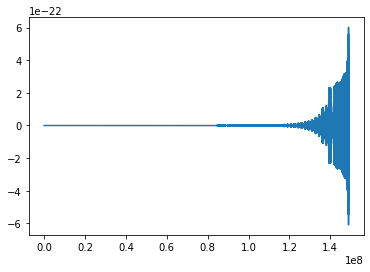

In [11]:
dom= myt[:-1000]
plt.plot(dom, myint(dom).real - fewint(dom).real)

In [3]:
tmparr = np.linspace(1,9,9,dtype=np.int64) #strange floating point error when doing just np.arange(1,10,0.1) for np.linspace(1,10,91). Causes issues when saving numbers to filenames
SMBHMasses = sorted([int(i) for i in np.kron(tmparr,[1e5, 1e6,1e7])]) #solar masses
SMBHSpins = [int(100*i)/100 for i in np.linspace(0.6,0.9,10)]
SecondaryMass = 10 #solar masses
e0list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
ProcaMasses = [round(i,22) for i in np.kron(tmparr, [1e-16,1e-17,1e-18,1e-19])] #eV   #again avoiding floating point errors
coords = cartesian_product(np.array(SMBHMasses),np.array(SMBHSpins), np.array(ProcaMasses), np.array(e0list))

In [7]:
newcoord = []
for arg in coords:
    alphaval = alphavalue(arg[0], arg[2])
    if alphaval>0.02 and alphaval<BHSpinAlphaCutoff(arg[1]):
        newcoord.append(arg)

In [8]:
len(newcoord)

16261